# Exploring Elkhorn Slough nutrient data from CDMO
Source: https://cdmo.baruch.sc.edu/

#### Data download details: 

Station(s): ELKAPNUT, ELKNMNUT, ELKSMNUT, ELKVMNUT 

Parameter(s): PO4F, F_PO4F, EC_PO4F, PO4F_C, NH4F, F_NH4F, EC_NH4F, NH4F_C, NO2F, F_NO2F, EC_NO2F, NO2F_C, NO3F, F_NO3F, EC_NO3F, NO3F_C, NO23F, F_NO23F, EC_NO23F, NO23F_C, CHLA_N, F_CHLA_N, EC_CHLA_N, CHLA_N_C

Dates: 01/01/2000 - 3/29/2024

In [1]:
# module importing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re


# establishing custom heatmap setup
import matplotlib as mpl 
import matplotlib.colors as colors

heat = mpl.colormaps['Spectral_r']
heat.set_extremes(bad='dimgray', under='dimgray', over='lightgray')

def make_norm(matrix):
    return colors.SymLogNorm(matrix.unstack().abs().median(),
                             base=2,vmin=-0.99999,vmax=0.99999)

### Importing data from .csv file; investigating null values

In [9]:
nut_df = pd.DataFrame(pd.read_csv('cdmo_elkhorn_slough_nutrients_raw.csv'))
nut_df.head()

StationCode isSWMP    DateTimeStamp  CollMethd  REP F_Record  PO4F   
0  elkapnut        P  04/01/2002 5:30          1    1      NaN   NaN  \
1  elkapnut        P  04/01/2002 5:30          1    2      NaN   NaN   
2  elknmnut        P  04/01/2002 5:50          1    1      NaN   NaN   
3  elknmnut        P  04/01/2002 5:50          1    2      NaN   NaN   
4  elksmnut        P  04/01/2002 6:30          1    1      NaN   NaN   

                      F_PO4F  NH4F                     F_NH4F  ...   
0  <4>  M - K                  NaN  <4>  M - K                 ...  \
1  <4>  M - K                  NaN  <4>  M - K                 ...   
2  <4>  M - K                  NaN  <4>  M - K                 ...   
3  <4>  M - K                  NaN  <4>  M - K                 ...   
4  <4>  M - K                  NaN  <4>  M - K                 ...   

   Unnamed: 18 Unnamed: 19  Unnamed: 20 Unnamed: 21  Unnamed: 22 Unnamed: 23   
0          NaN         NaN          NaN         NaN          NaN         NaN  \
1          NaN         NaN          NaN         NaN          NaN         NaN   
2          NaN         NaN          NaN         NaN          NaN         NaN   
3          NaN         NaN          NaN         NaN          NaN         NaN   
4          NaN         NaN          NaN         NaN          NaN         NaN   

   Unnamed: 24 Unnamed: 25  Unnamed: 26  Unnamed: 27  
0          NaN         NaN          NaN          NaN  
1          NaN         NaN          NaN          NaN  
2          NaN         NaN          NaN          NaN  
3          NaN         NaN          NaN          NaN  
4          NaN         NaN          NaN          NaN  

[5 rows x 28 columns]

StationCode         0
isSWMP              0
DateTimeStamp       0
CollMethd           0
REP                 0
F_Record         6176
PO4F              268
F_PO4F              0
NH4F              620
F_NH4F              0
NO2F              252
F_NO2F              0
NO3F              628
F_NO3F              0
NO23F             273
F_NO23F             0
CHLA_N            301
F_CHLA_N            0
Unnamed: 18      6182
Unnamed: 19      6182
Unnamed: 20      6182
Unnamed: 21      6182
Unnamed: 22      6182
Unnamed: 23      6182
Unnamed: 24      6182
Unnamed: 25      6182
Unnamed: 26      6182
Unnamed: 27      6182
dtype: int64


<Axes: >

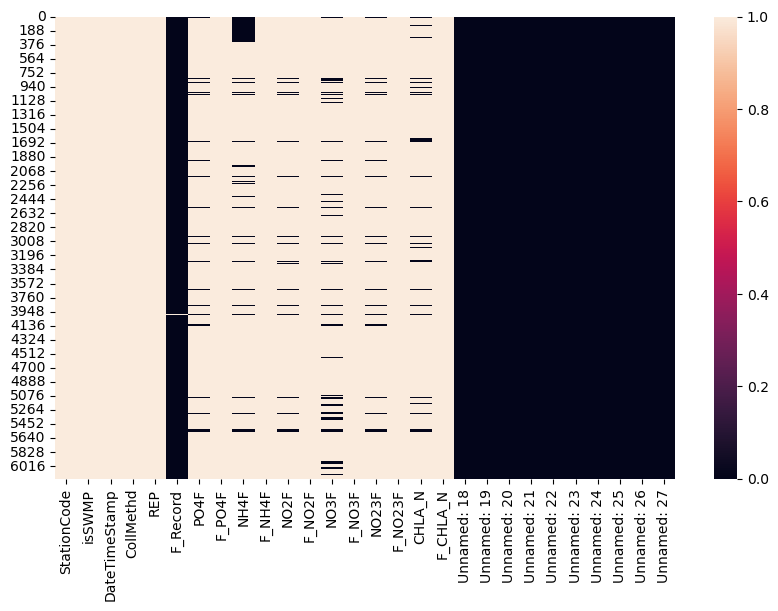

In [8]:
print(nut_df.isna().sum())
plt.figure(figsize=(10,6))
sns.heatmap(data=nut_df.notna())

Several columns are almost exclusively missing values. Next I drop all columns with more than 6,000 missing values.

In [12]:
nut_df.drop(labels = list(nut_df.columns[nut_df.isna().sum() > 6000]), axis = 1, inplace=True)
nut_df.columns

Index(['StationCode', 'isSWMP', 'DateTimeStamp', 'CollMethd', 'REP', 'PO4F',
       'F_PO4F', 'NH4F', 'F_NH4F', 'NO2F', 'F_NO2F', 'NO3F', 'F_NO3F', 'NO23F',
       'F_NO23F', 'CHLA_N', 'F_CHLA_N'],
      dtype='object')

Previously, I had this set up to drop all rows that had any missing values. That's no longer necessary - you'll see why in a minute. Here I copy the dataframe and mess with columns a bit more.

In [4]:
nut_df_clean = nut_df.copy().drop(labels=[x for x in nut_df if re.match("^F_|isSWMP",x)],axis=1)
nut_df_clean['DateTimeStamp'] = pd.to_datetime(nut_df_clean['DateTimeStamp'])

Now I turn it into tidy, or long-form, data. Five nutrient columns are melted into `variable` and `value` columns; the rest are used as ID columns. Then I add a column `value_log` which should be pretty self explanatory, and a bunch more time-related columns about year and time of year. 

In [13]:
nut_df_tidy = pd.melt(nut_df_clean, id_vars=['StationCode','DateTimeStamp','CollMethd','REP','CHLA_N'],
                       value_vars=['PO4F','NH4F','NO2F','NO3F','NO23F'])
nut_df_tidy['value_log'] = [0 if x <= 0 else np.log(x) for x in nut_df_tidy.value]
nut_df_tidy['Int_Year'] = pd.Series([int(x[0:4]) for x in np.datetime_as_string(nut_df_tidy.DateTimeStamp)])
nut_df_tidy['DateTime_Year'] = pd.to_datetime(pd.Series([x[0:4] for x 
                                                         in np.datetime_as_string(nut_df_tidy.DateTimeStamp)]))
nut_df_tidy['DateTime_MonDay'] = pd.to_timedelta(nut_df_tidy['DateTimeStamp'] - nut_df_tidy['DateTime_Year'],'D')
nut_df_tidy['Float_MonDay'] = pd.Series(nut_df_tidy['DateTime_MonDay'] / np.timedelta64(365,'D'))
nut_df_tidy.dropna(axis='index',how='any',inplace=True)

NameError: name 'nut_df_clean' is not defined

In [14]:
nut_df_tidy.describe()

NameError: name 'nut_df_tidy' is not defined

## Exploratory Data Visualizations
Dunno what's going on in here mostly. 

<Figure size 2000x2000 with 0 Axes>

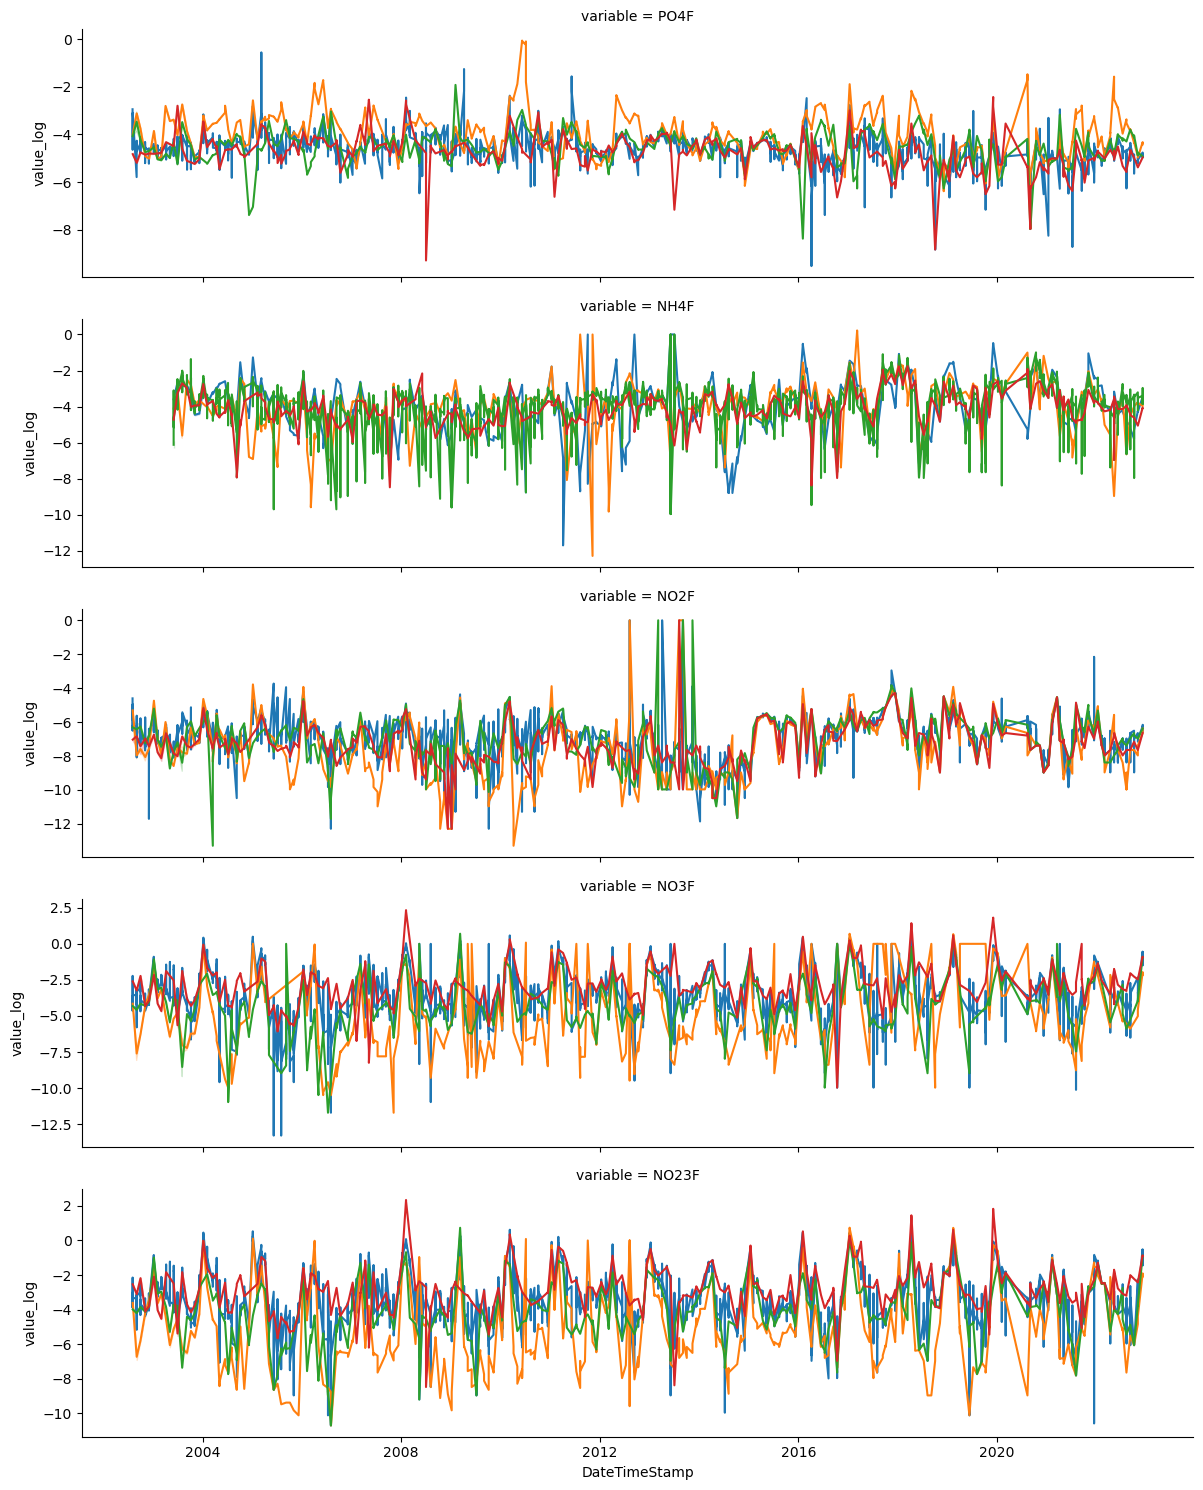

In [8]:
plt.figure(figsize=(20,20))
g = sns.FacetGrid(nut_df_tidy,row='variable',legend_out=True, sharex=True, sharey=False, height=3.0, aspect=4.0)
g.map_dataframe(sns.lineplot,x='DateTimeStamp',y='value_log',hue='StationCode')

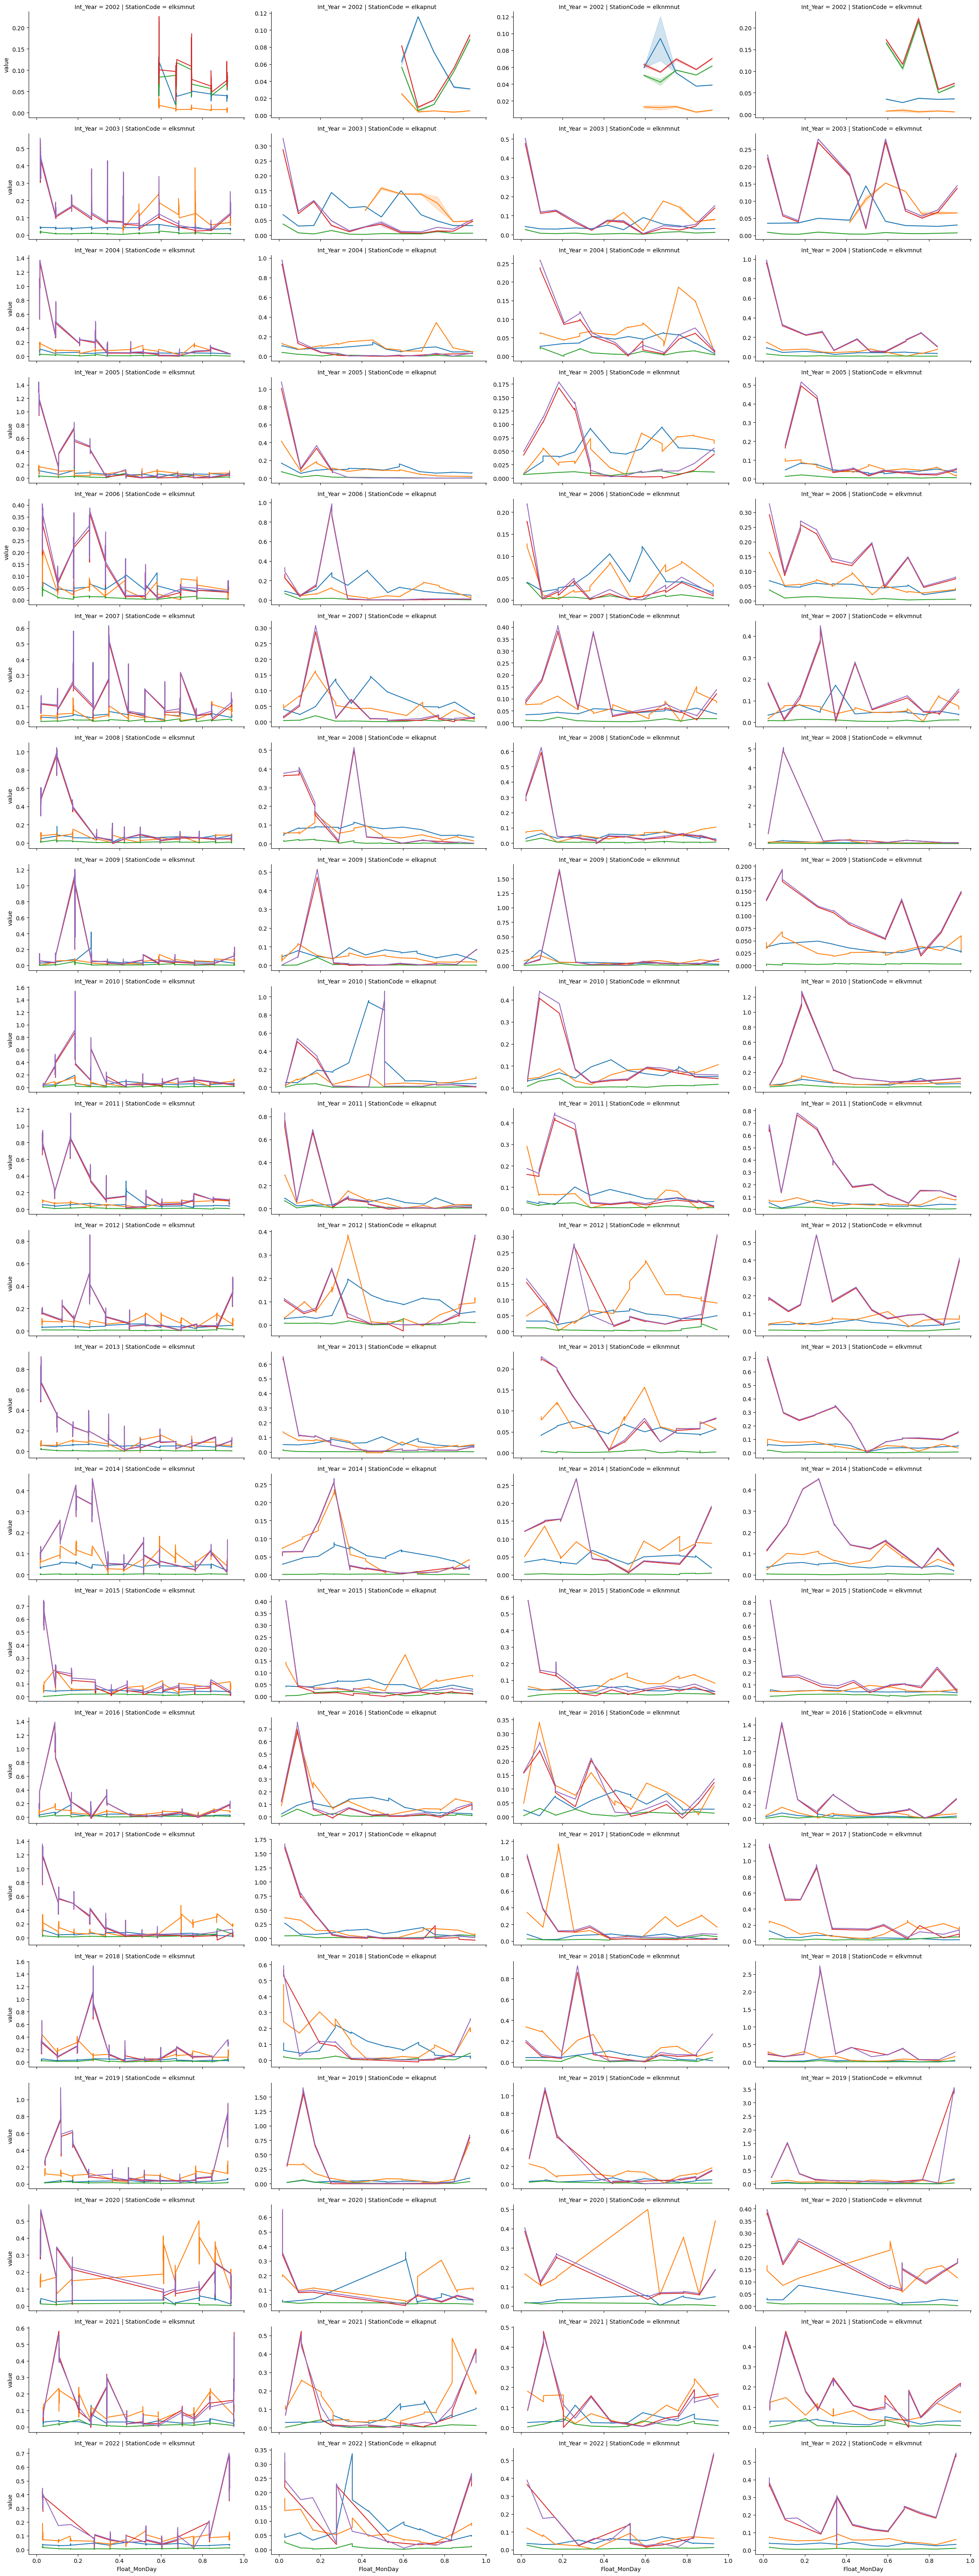

In [12]:
g = sns.FacetGrid(nut_df_tidy,row='Int_Year',col='StationCode',legend_out=False, 
                  sharex=True, sharey=False, height=3.0, aspect=2.0)
g.map_dataframe(sns.lineplot,x='Float_MonDay',y='value',hue='variable')

KeyboardInterrupt: 

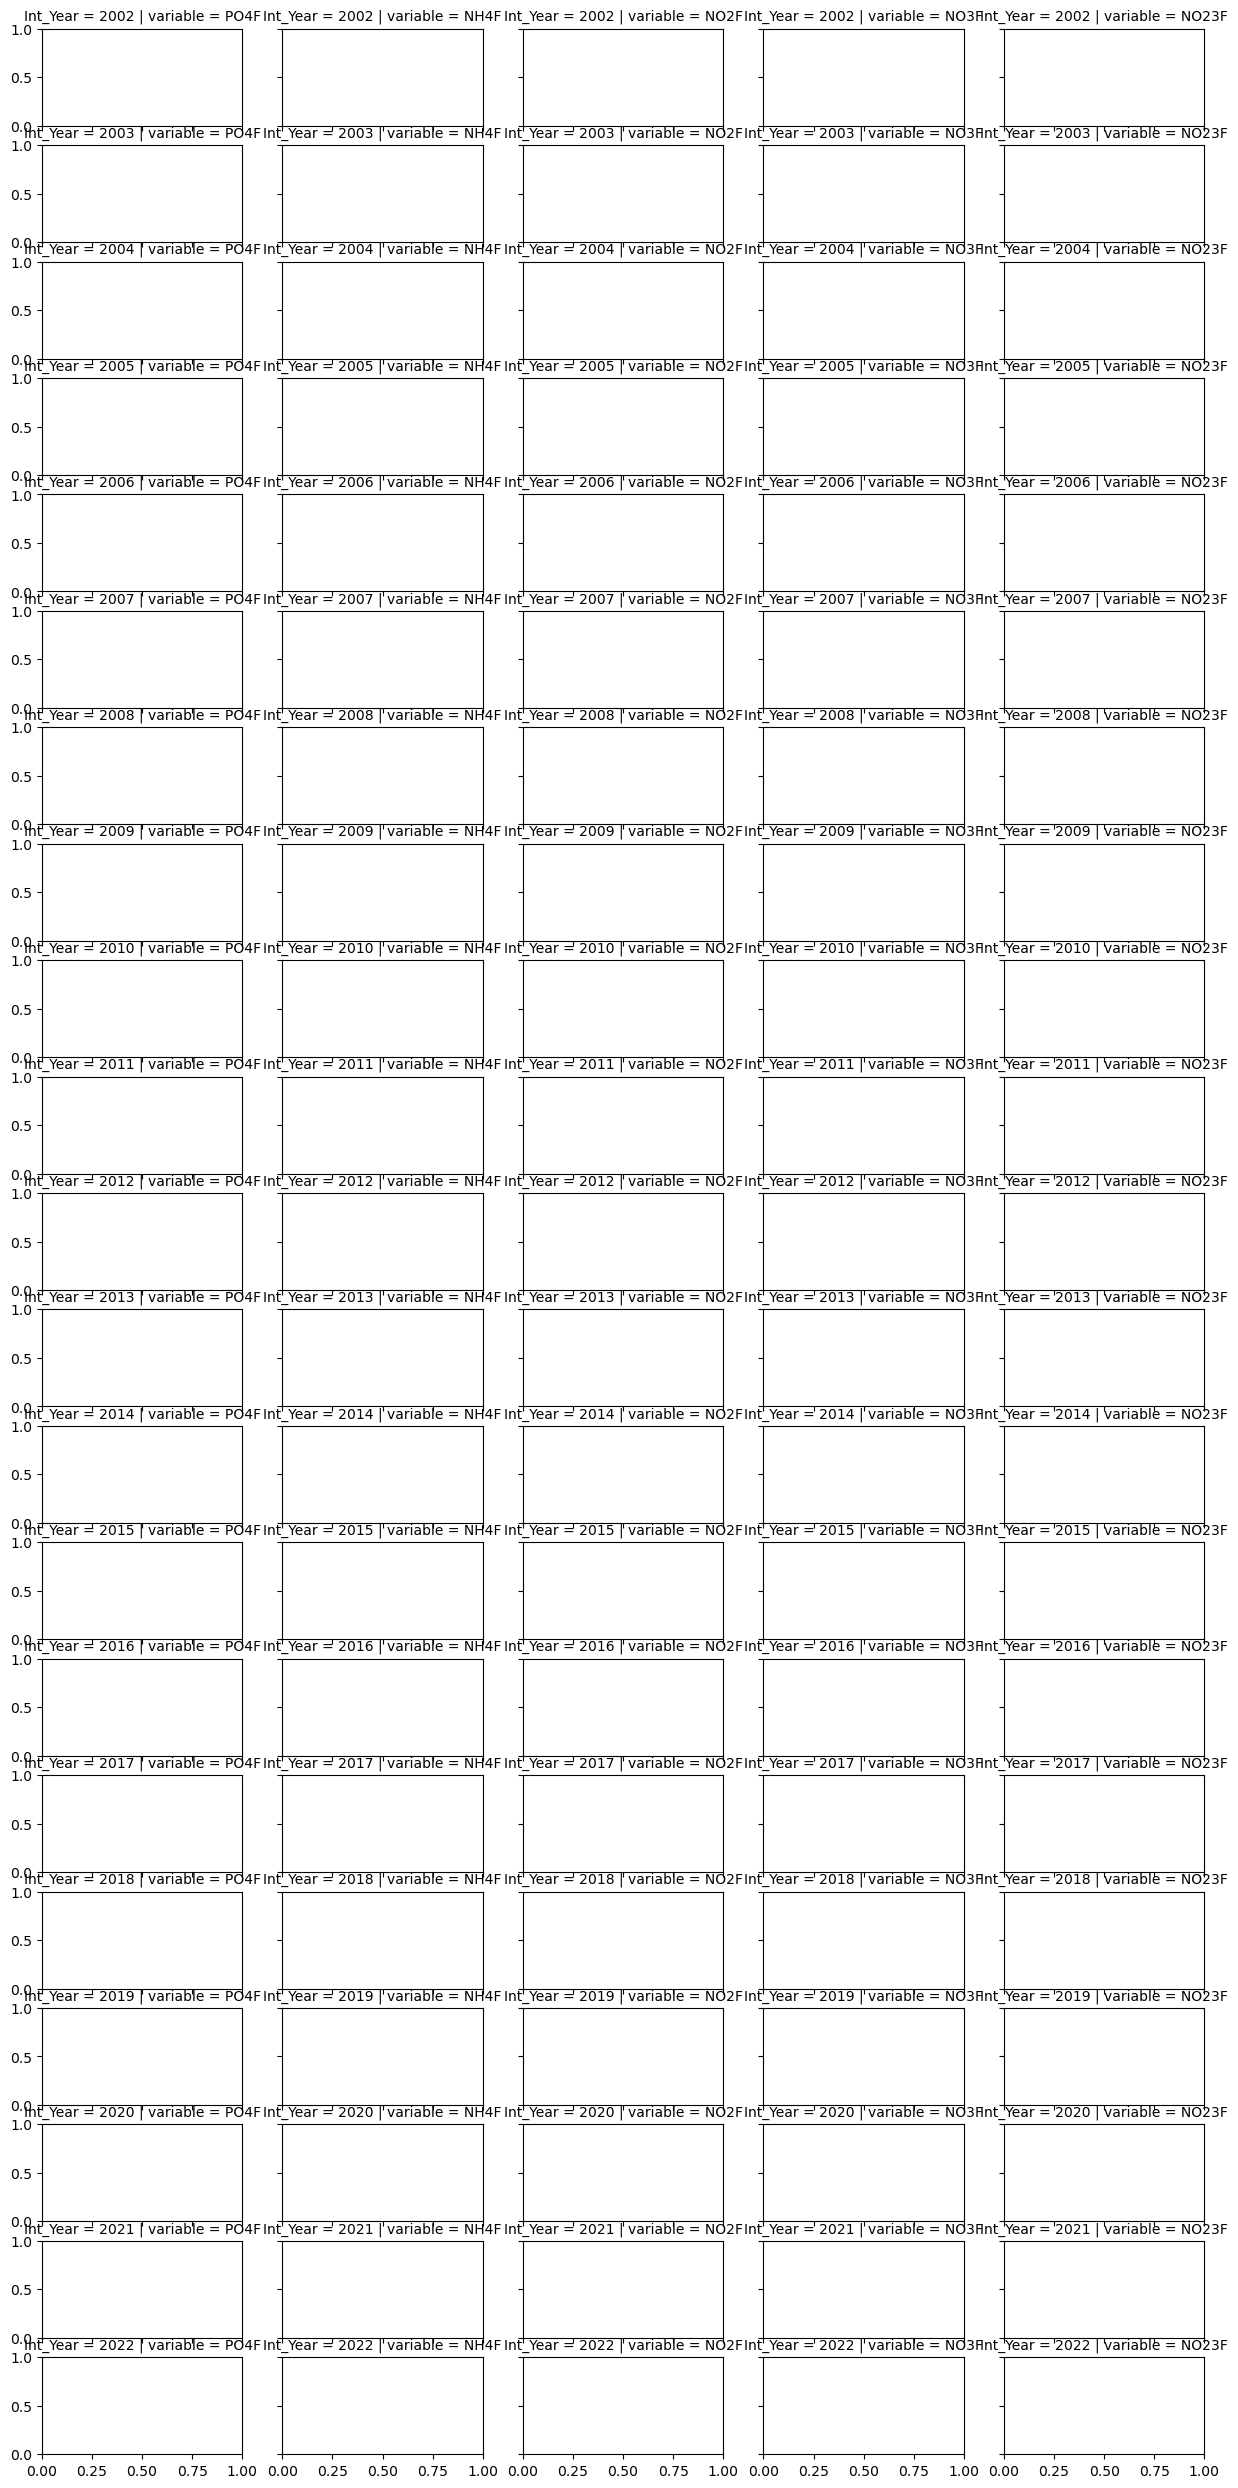

In [7]:
g = sns.FacetGrid(nut_df_tidy,row='Int_Year',col='variable',legend_out=False, 
                  sharex=True, sharey=True, height=1.5, aspect=2.0)
g.map_dataframe(sns.lineplot,x='Float_MonDay',y='value_log',hue='StationCode')

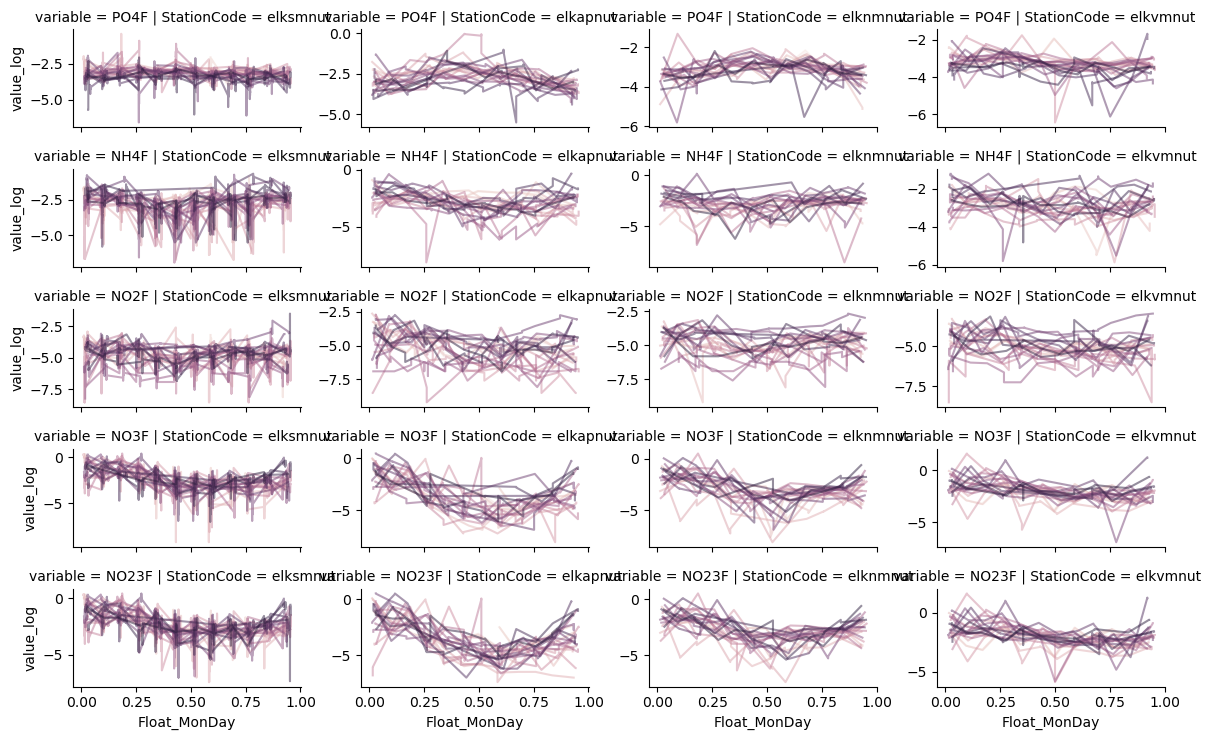

In [13]:
g = sns.FacetGrid(nut_df_tidy.loc[nut_df_tidy.value > 0],row='variable',col='StationCode',legend_out=False, 
                  sharex=True, sharey=False, height=1.5, aspect=2.0)
g.map_dataframe(sns.lineplot,x='Float_MonDay',y='value_log',hue='Int_Year',alpha=0.5)

<Axes: xlabel='Float_MonDay', ylabel='value_log'>

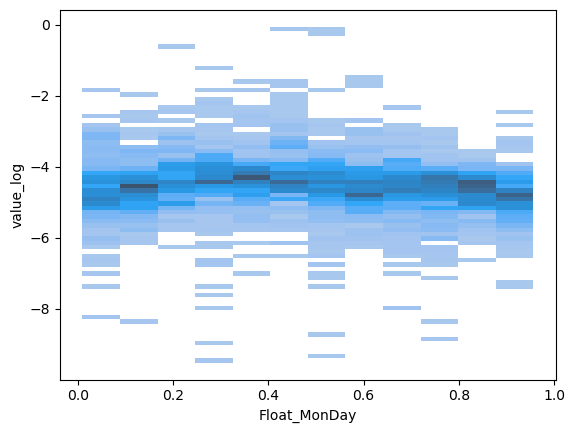

In [44]:
sns.histplot(nut_df_tidy.loc[nut_df_tidy['variable']=='PO4F'], 
             x='Float_MonDay',y='value_log',bins=(12,'sqrt'))

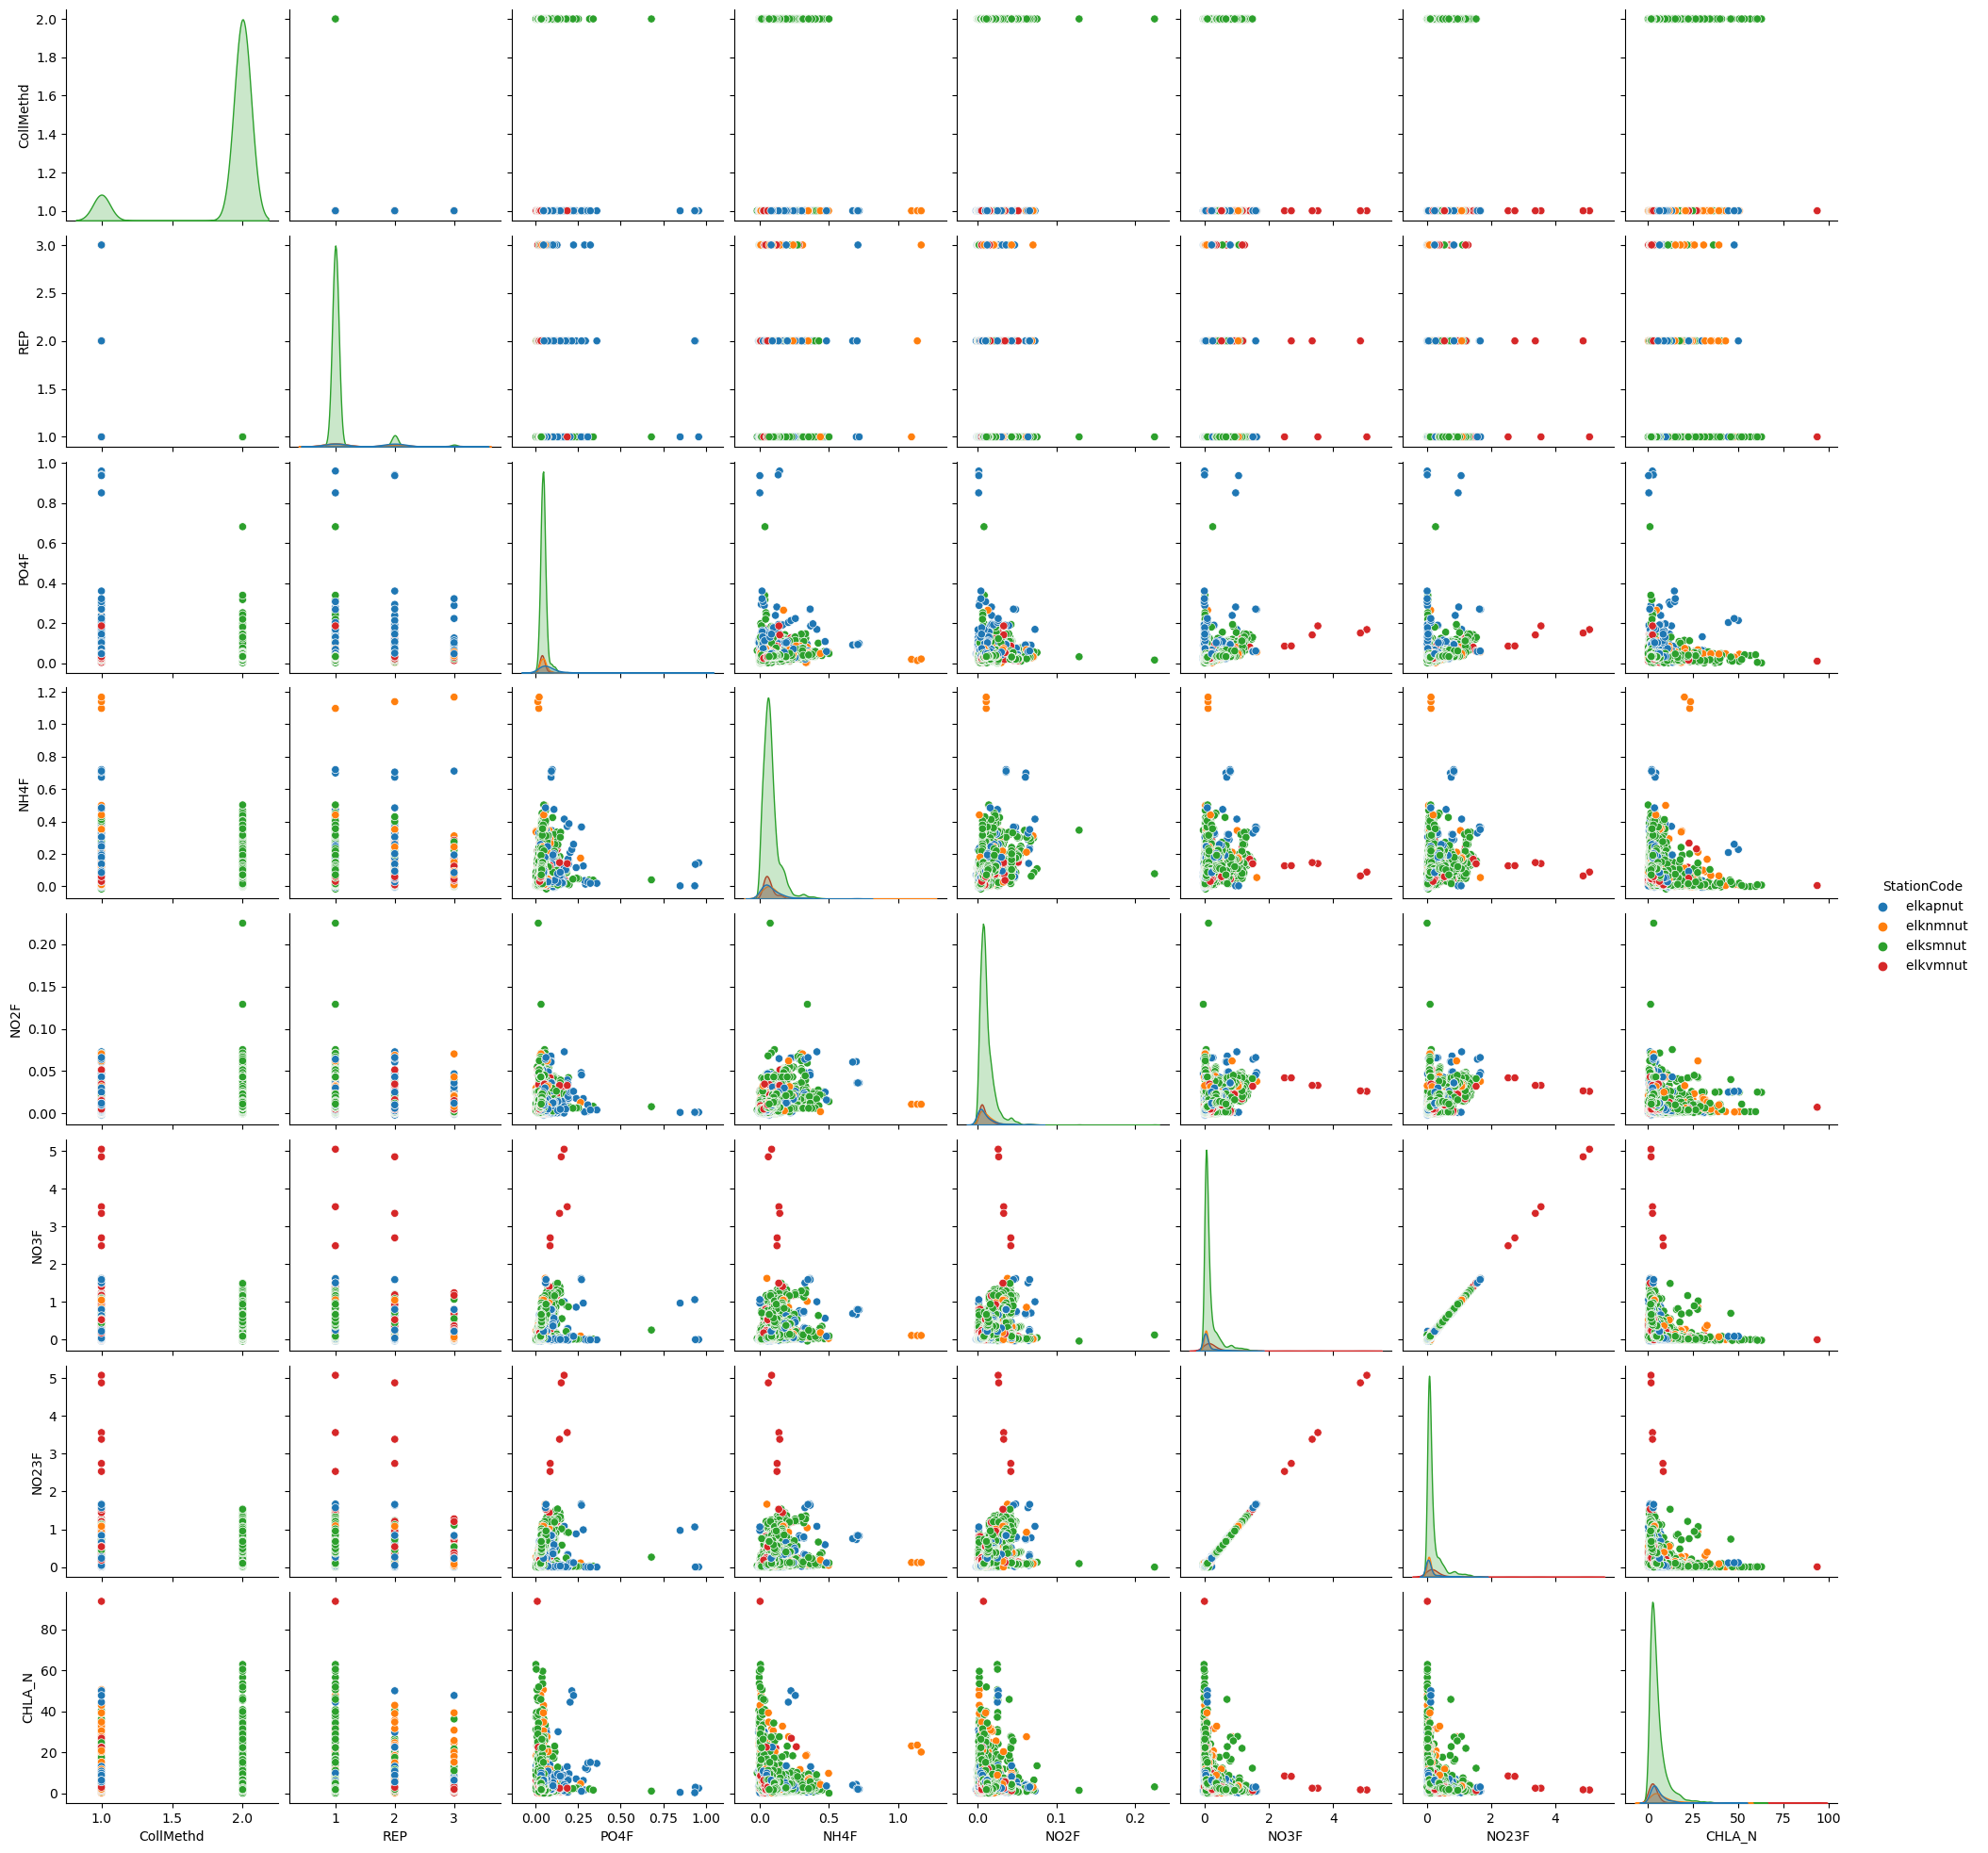

In [40]:
sns.pairplot(nut_df_clean, hue='StationCode')

Down here is some much older stuff working on much less cleaned data. I feel bad deleting it, but it's not doing much.

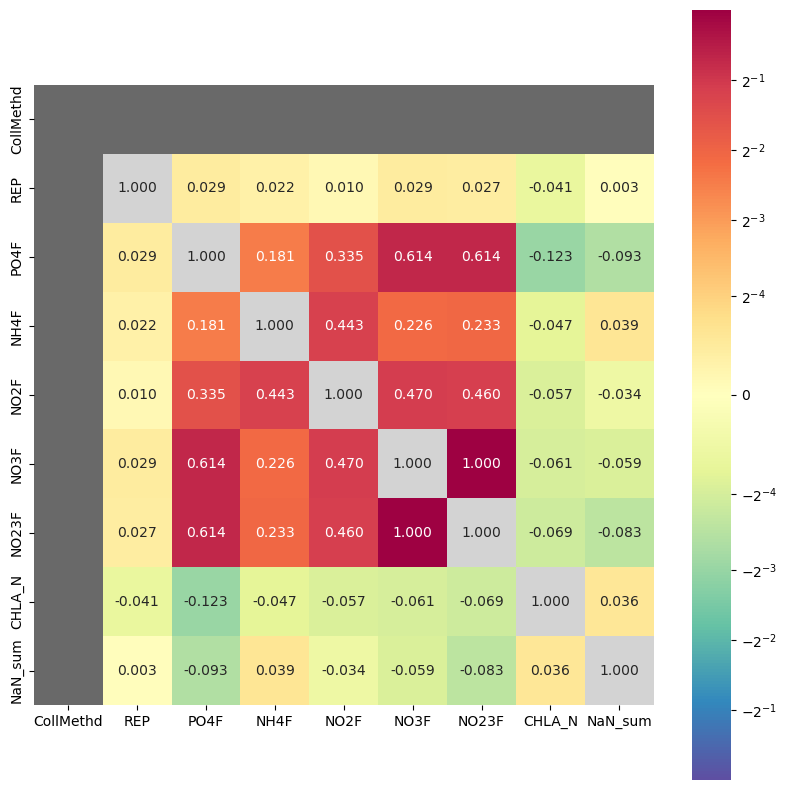

In [44]:
corrmat = elkvmnut_df.corr(numeric_only=True)

plt.figure(figsize=(10,10))
heatmap_fig = sns.heatmap(data=corrmat,
                        annot=True, fmt = '.3f',
                        square = True,
                        cmap=heat,
                        norm=make_norm(corrmat)
                        );

In [14]:
# so that 0.999 corr between NO3F and NO23F is. crazy. 
# observations from `elkapnut` all have same CollMethd, 
    # which returns 'bad' values for an elkapnut-only correlation heatmap
    # same with `elknmnut` and `elkvmnut` actually
    

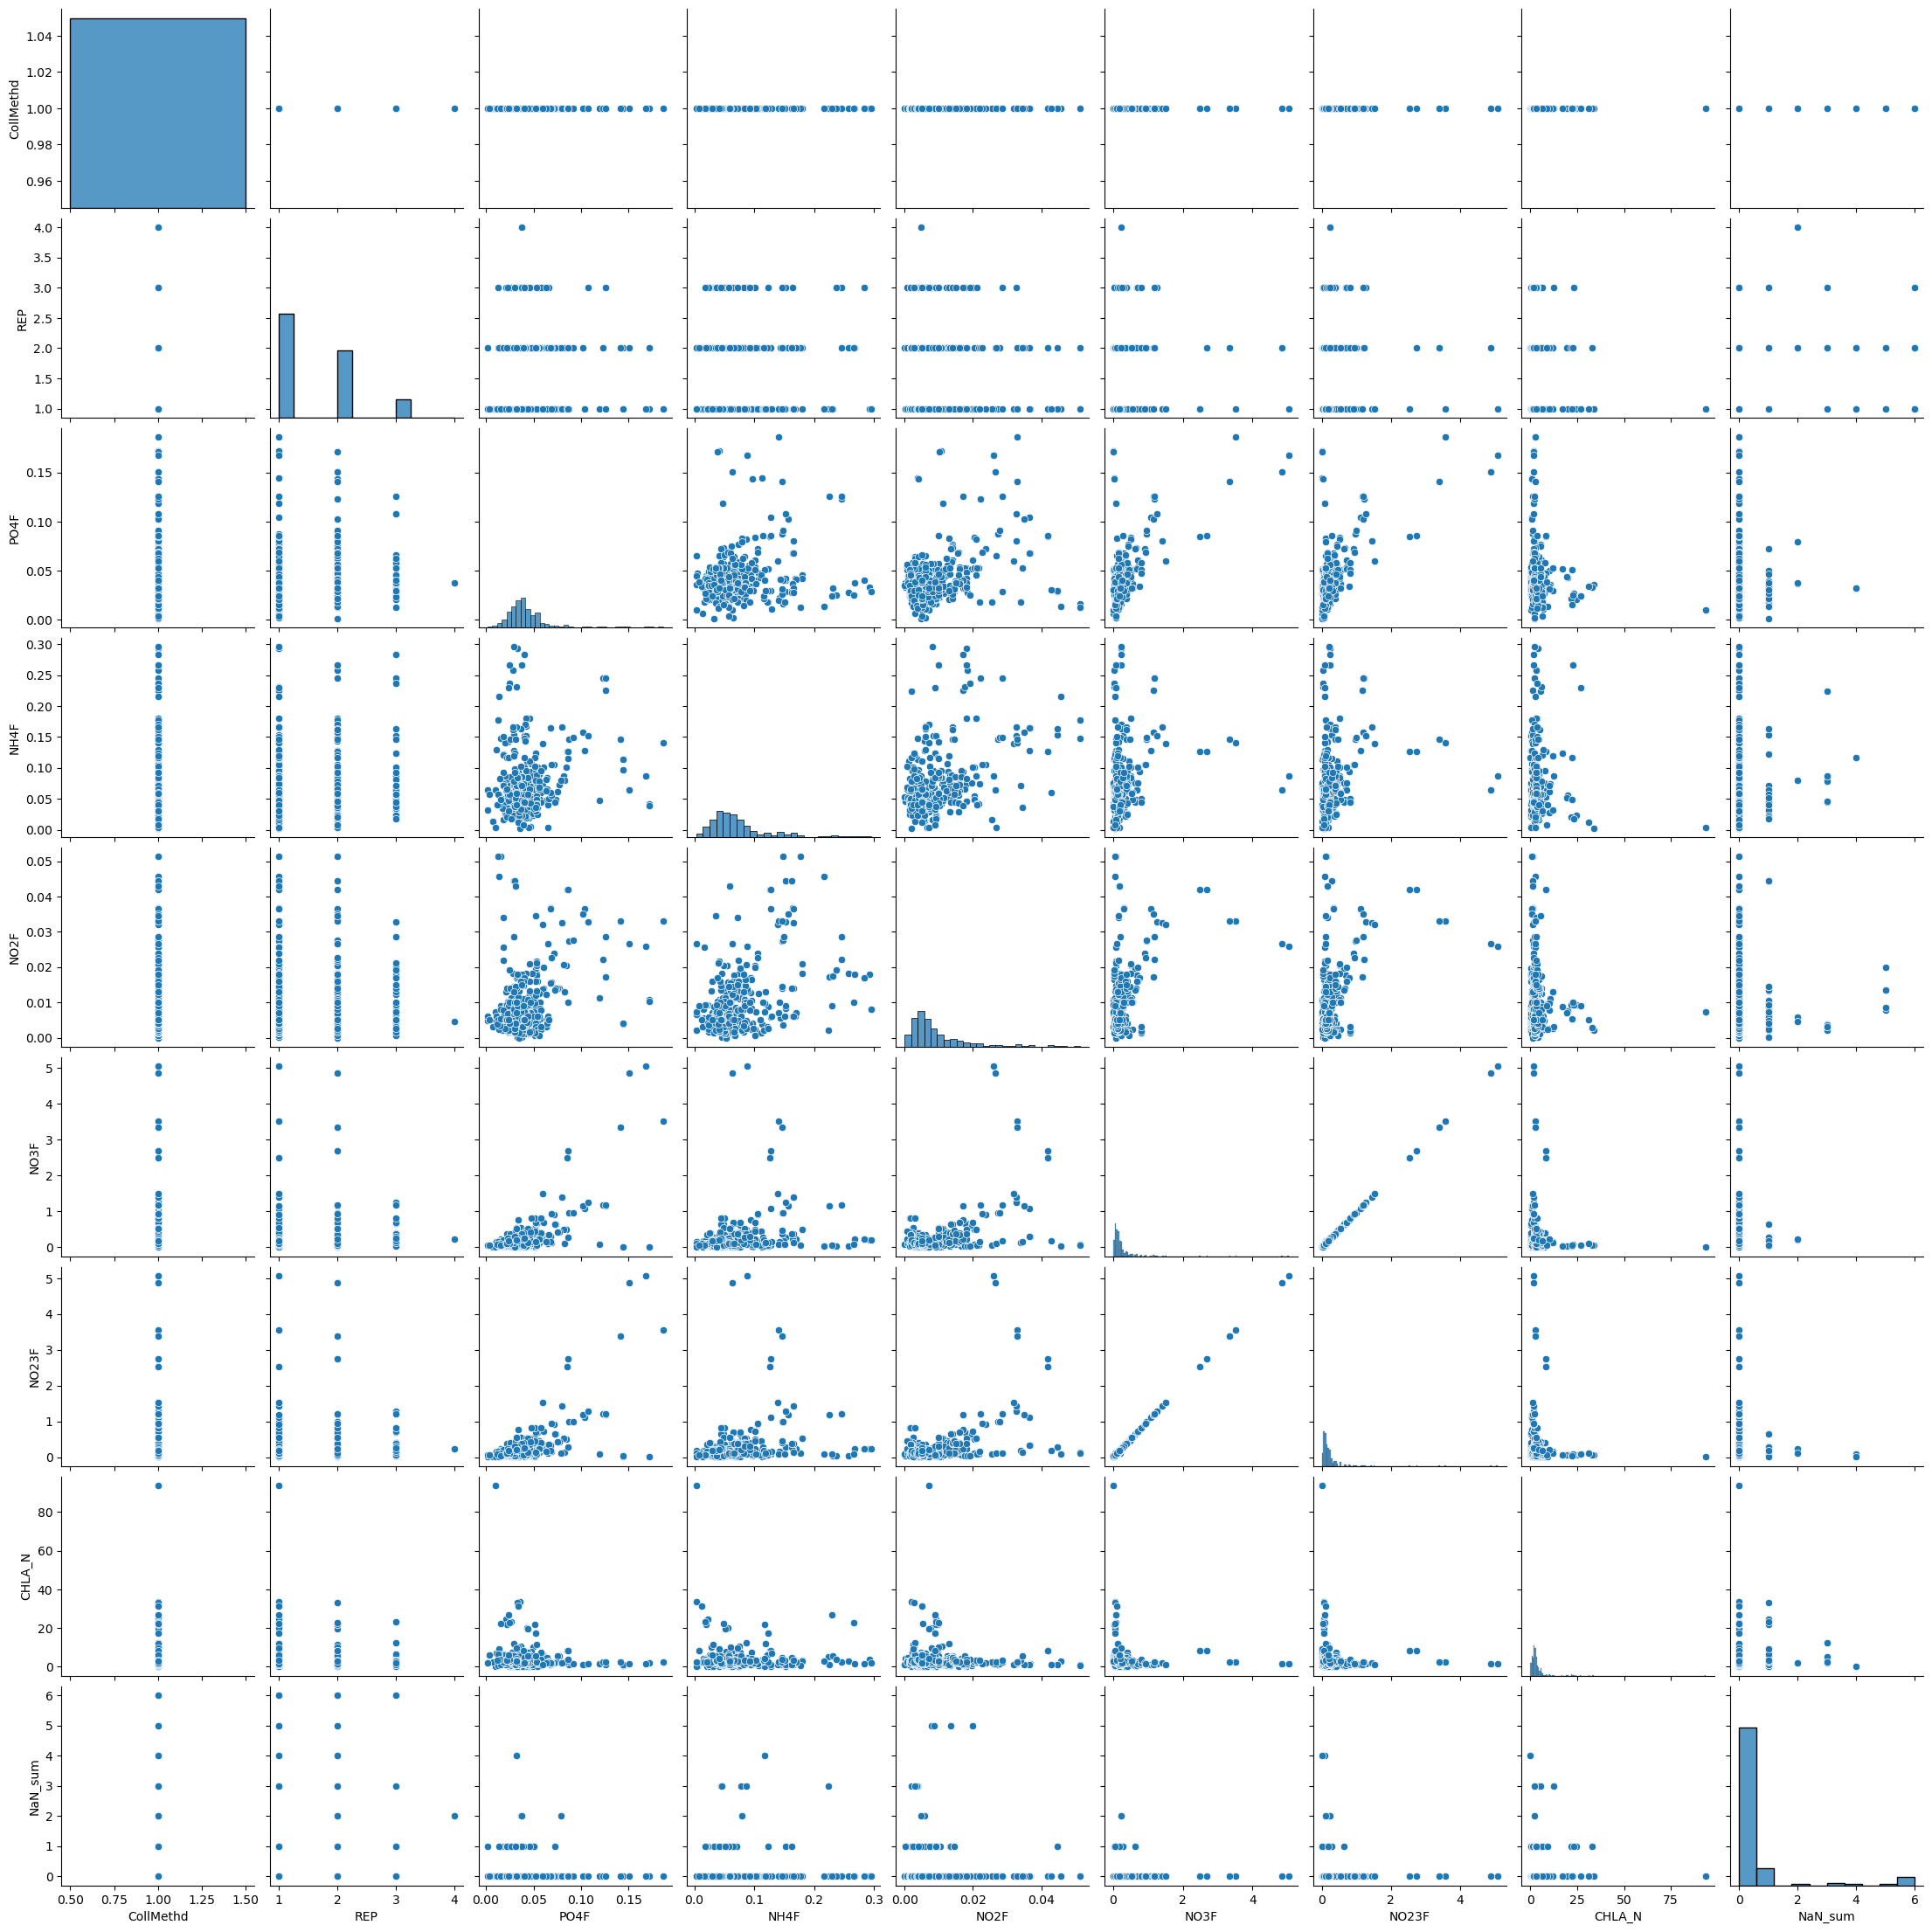

In [46]:
sns.pairplot(elkvmnut_df)